In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import datanewn as dt
import model_FCN_U as md
import copy
from torch.utils.data import DataLoader, ConcatDataset
import torchvision.transforms as transforms
from pytorch_ssim import ssim
import pytorch_edgeloss
# fcn+U

In [2]:
# print gpu
torch.cuda.set_device(0)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 0
8
(7, 0)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = "cpu"
print(device)

cuda:0


In [ ]:
# generate csv file, run only for the first time
import csvgenerator as csvg
# csvg.generate_csv()

In [ ]:
# csvFilePath = dt.get_csv_path()
# print(csvFilePath)
# transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
#                                                transform=dt.Compose([                                              
#                                                dt.Rescale(96),                                     
#                                                dt.Normalize(),
#                                                dt.ToTensor()
#                                            ]))
# # TODO: change the normalization parameters

In [ ]:
# # batchsize 32->16
# dataloader = DataLoader(transformed_dataset, batch_size=80,
#                         shuffle=True, num_workers=0)
# print(len(transformed_dataset))

In [ ]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [4]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'fcnU_0412_3.pth')
model = md.Net()
model.load_state_dict(torch.load(path))
model.eval()

Net(
  (block0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
  )
  (info1): Sequential(
    (0): Conv2d(64,

In [13]:
criterionMSE = nn.MSELoss()
criterionMSE = criterionMSE.cuda()
criterionEdge = pytorch_edgeloss.EDGE()
criterionEdge = criterionEdge.cuda()
criterionL1 = nn.L1Loss()
criterionL1 = criterionL1.cuda()

In [6]:
model = model.to(device)

In [ ]:
model = md.Net().to(device)

In [14]:
def trainMS(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
#         lossMSE = criterionMSE(output, targetf)  
        lossMSE = criterionEdge(output, targetf)
#         lossSSIM = 1-ssim(output, targetf, windowsize)
        lossSSIM = criterionL1(output, targetf)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossEdge: " + str(lossMSE.item()) +
                  " " + "lossL1: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))

In [15]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            
            input = input[0:32, :, :, :]
            input_batch = input_batch[0:32, :, :, :]
            label_batch = label_batch[0:32, :, :]
            
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           
            grid = utils.make_grid(input).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()
    
            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
#             targetf = target[:, None]
            
#             lossMSE = criterionL(prediction, targetf)      
#             lossSSIM = -ssim(prediction, targetf)
        
#             p = 0.25
#             loss = p*lossMSE + (1-p)*lossSSIM
#             combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
# #             mse = criterion(prediction, target.float())

#             psnr = 10 * torch.log10(1 / loss)
#             avg_psnr += psnr
            if iteration == 16:
                break
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

In [19]:
import os
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'fcnU_0413.pth')
torch.save(model.state_dict(), path)

In [ ]:
test()

In [9]:
import dataaug as dta
csvFilePath = dta.get_csv_path()
transformed_datasetH = dta.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dta.Compose([                                              
                                               dta.Rescale(96),                                     
                                               dta.Normalize(),
                                               dta.FlipH(),
                                               dta.ToTensor()
                                           ]))
transformed_datasetV = dta.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dta.Compose([                                              
                                               dta.Rescale(96),                                     
                                               dta.Normalize(),
                                               dta.FlipV(),
                                               dta.ToTensor()
                                           ]))
transformed_dataset = dta.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dta.Compose([                                              
                                               dta.Rescale(96),                                     
                                               dta.Normalize(),
                                               dta.ToTensor()
                                           ]))
dataset = ConcatDataset((transformed_datasetH, transformed_datasetV, transformed_dataset))
dataloader = DataLoader(dataset, batch_size=100,
                        shuffle=True, num_workers=0)
print(len(dataset))

3012972


In [10]:
l = 0.0001
p = 0.75
windowsize = 11
for epoch in range(1, 200 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*1
        l = l*1
        if windowsize >= 11:
            windowsze = 11
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    trainMS(epoch, p, windowsize)

lossMSE: 0.22445926070213318 lossSSIM: 0.4655025601387024
===> Epoch[1](0/30130): Loss: 0.2847
lossMSE: 0.23082727193832397 lossSSIM: 0.4529969096183777
===> Epoch[1](50/30130): Loss: 0.2864
lossMSE: 0.21855716407299042 lossSSIM: 0.4554763436317444
===> Epoch[1](100/30130): Loss: 0.2778
lossMSE: 0.21614579856395721 lossSSIM: 0.4637581706047058
===> Epoch[1](150/30130): Loss: 0.2780
lossMSE: 0.2089088261127472 lossSSIM: 0.43935245275497437
===> Epoch[1](200/30130): Loss: 0.2665
lossMSE: 0.22621099650859833 lossSSIM: 0.4433938264846802
===> Epoch[1](250/30130): Loss: 0.2805
lossMSE: 0.21817362308502197 lossSSIM: 0.44768911600112915
===> Epoch[1](300/30130): Loss: 0.2756
lossMSE: 0.23381225764751434 lossSSIM: 0.45787137746810913
===> Epoch[1](350/30130): Loss: 0.2898
lossMSE: 0.17988498508930206 lossSSIM: 0.41217201948165894
===> Epoch[1](400/30130): Loss: 0.2380
lossMSE: 0.2192165106534958 lossSSIM: 0.44616734981536865
===> Epoch[1](450/30130): Loss: 0.2760
lossMSE: 0.20943577587604523 l

KeyboardInterrupt: 

In [16]:
l = 0.0001
p = 0.75
windowsize = 11
for epoch in range(1, 200 + 1):
    if epoch%5 == 0:
        windowsize = windowsize+1
        p = p*1
        l = l*1
        if windowsize >= 11:
            windowsze = 11
    optimizer = optim.Adam(model.parameters(), lr=l)
        
    trainMS(epoch, p, windowsize)

lossEdge: 0.18507446348667145 lossL1: 0.047300562262535095
===> Epoch[1](0/30130): Loss: 0.1506
lossEdge: 0.21730823814868927 lossL1: 0.060331813991069794
===> Epoch[1](50/30130): Loss: 0.1781
lossEdge: 0.23054565489292145 lossL1: 0.058717161417007446
===> Epoch[1](100/30130): Loss: 0.1876
lossEdge: 0.1784277856349945 lossL1: 0.046815089881420135
===> Epoch[1](150/30130): Loss: 0.1455
lossEdge: 0.19374142587184906 lossL1: 0.05459222570061684
===> Epoch[1](200/30130): Loss: 0.1590
lossEdge: 0.2026112973690033 lossL1: 0.05252327024936676
===> Epoch[1](250/30130): Loss: 0.1651
lossEdge: 0.24708496034145355 lossL1: 0.0645991712808609
===> Epoch[1](300/30130): Loss: 0.2015
lossEdge: 0.22722509503364563 lossL1: 0.06179433315992355
===> Epoch[1](350/30130): Loss: 0.1859
lossEdge: 0.22984714806079865 lossL1: 0.05852269381284714
===> Epoch[1](400/30130): Loss: 0.1870
lossEdge: 0.22471043467521667 lossL1: 0.05725705623626709
===> Epoch[1](450/30130): Loss: 0.1828
lossEdge: 0.24097737669944763 lo

lossEdge: 0.21355265378952026 lossL1: 0.058704081922769547
===> Epoch[1](4250/30130): Loss: 0.1748
lossEdge: 0.21813616156578064 lossL1: 0.0574471689760685
===> Epoch[1](4300/30130): Loss: 0.1780
lossEdge: 0.23419012129306793 lossL1: 0.06288349628448486
===> Epoch[1](4350/30130): Loss: 0.1914
lossEdge: 0.17565138638019562 lossL1: 0.050243671983480453
===> Epoch[1](4400/30130): Loss: 0.1443
lossEdge: 0.20787683129310608 lossL1: 0.05476978048682213
===> Epoch[1](4450/30130): Loss: 0.1696
lossEdge: 0.19406481087207794 lossL1: 0.05208153277635574
===> Epoch[1](4500/30130): Loss: 0.1586
lossEdge: 0.2544978857040405 lossL1: 0.06908079981803894
===> Epoch[1](4550/30130): Loss: 0.2081
lossEdge: 0.22995077073574066 lossL1: 0.05950896814465523
===> Epoch[1](4600/30130): Loss: 0.1873
lossEdge: 0.23140713572502136 lossL1: 0.05983421206474304
===> Epoch[1](4650/30130): Loss: 0.1885
lossEdge: 0.2274550050497055 lossL1: 0.06416723877191544
===> Epoch[1](4700/30130): Loss: 0.1866
lossEdge: 0.202790990

lossEdge: 0.20956452190876007 lossL1: 0.05473265051841736
===> Epoch[1](8450/30130): Loss: 0.1709
lossEdge: 0.19330757856369019 lossL1: 0.052632711827754974
===> Epoch[1](8500/30130): Loss: 0.1581
lossEdge: 0.2098294496536255 lossL1: 0.05489150434732437
===> Epoch[1](8550/30130): Loss: 0.1711
lossEdge: 0.2393898069858551 lossL1: 0.06410808861255646
===> Epoch[1](8600/30130): Loss: 0.1956
lossEdge: 0.22557121515274048 lossL1: 0.057536620646715164
===> Epoch[1](8650/30130): Loss: 0.1836
lossEdge: 0.20419172942638397 lossL1: 0.052112095057964325
===> Epoch[1](8700/30130): Loss: 0.1662
lossEdge: 0.24081000685691833 lossL1: 0.06479597836732864
===> Epoch[1](8750/30130): Loss: 0.1968
lossEdge: 0.19655419886112213 lossL1: 0.0498499721288681
===> Epoch[1](8800/30130): Loss: 0.1599
lossEdge: 0.19442689418792725 lossL1: 0.05293799191713333
===> Epoch[1](8850/30130): Loss: 0.1591
lossEdge: 0.20797713100910187 lossL1: 0.05543886125087738
===> Epoch[1](8900/30130): Loss: 0.1698
lossEdge: 0.22583886

lossEdge: 0.2337864190340042 lossL1: 0.05992935597896576
===> Epoch[1](12650/30130): Loss: 0.1903
lossEdge: 0.2009468674659729 lossL1: 0.050313085317611694
===> Epoch[1](12700/30130): Loss: 0.1633
lossEdge: 0.20850321650505066 lossL1: 0.05225083976984024
===> Epoch[1](12750/30130): Loss: 0.1694
lossEdge: 0.23423542082309723 lossL1: 0.06142454221844673
===> Epoch[1](12800/30130): Loss: 0.1910
lossEdge: 0.20214757323265076 lossL1: 0.05255765840411186
===> Epoch[1](12850/30130): Loss: 0.1648
lossEdge: 0.21865974366664886 lossL1: 0.0585087426006794
===> Epoch[1](12900/30130): Loss: 0.1786
lossEdge: 0.2158094197511673 lossL1: 0.05545732006430626
===> Epoch[1](12950/30130): Loss: 0.1757
lossEdge: 0.19651629030704498 lossL1: 0.051093172281980515
===> Epoch[1](13000/30130): Loss: 0.1602
lossEdge: 0.20816613733768463 lossL1: 0.05569487437605858
===> Epoch[1](13050/30130): Loss: 0.1700
lossEdge: 0.25359010696411133 lossL1: 0.06402062624692917
===> Epoch[1](13100/30130): Loss: 0.2062
lossEdge: 0.

lossEdge: 0.19059820473194122 lossL1: 0.05296899750828743
===> Epoch[1](16800/30130): Loss: 0.1562
lossEdge: 0.21960076689720154 lossL1: 0.05155465751886368
===> Epoch[1](16850/30130): Loss: 0.1776
lossEdge: 0.17318940162658691 lossL1: 0.047953516244888306
===> Epoch[1](16900/30130): Loss: 0.1419
lossEdge: 0.21665380895137787 lossL1: 0.05611236020922661
===> Epoch[1](16950/30130): Loss: 0.1765
lossEdge: 0.1931927502155304 lossL1: 0.05085871368646622
===> Epoch[1](17000/30130): Loss: 0.1576
lossEdge: 0.23083771765232086 lossL1: 0.06196920573711395
===> Epoch[1](17050/30130): Loss: 0.1886
lossEdge: 0.21790145337581635 lossL1: 0.05468538776040077
===> Epoch[1](17100/30130): Loss: 0.1771
lossEdge: 0.21025848388671875 lossL1: 0.0515298955142498
===> Epoch[1](17150/30130): Loss: 0.1706
lossEdge: 0.19983382523059845 lossL1: 0.051486533135175705
===> Epoch[1](17200/30130): Loss: 0.1627
lossEdge: 0.20461860299110413 lossL1: 0.054083146154880524
===> Epoch[1](17250/30130): Loss: 0.1670
lossEdge:

lossEdge: 0.23513387143611908 lossL1: 0.06751035153865814
===> Epoch[1](20950/30130): Loss: 0.1932
lossEdge: 0.22491933405399323 lossL1: 0.05819686874747276
===> Epoch[1](21000/30130): Loss: 0.1832
lossEdge: 0.18970227241516113 lossL1: 0.04984095320105553
===> Epoch[1](21050/30130): Loss: 0.1547
lossEdge: 0.23070713877677917 lossL1: 0.06155276298522949
===> Epoch[1](21100/30130): Loss: 0.1884
lossEdge: 0.24287492036819458 lossL1: 0.05975343659520149
===> Epoch[1](21150/30130): Loss: 0.1971
lossEdge: 0.17756019532680511 lossL1: 0.04408106207847595
===> Epoch[1](21200/30130): Loss: 0.1442
lossEdge: 0.22091370820999146 lossL1: 0.055262137204408646
===> Epoch[1](21250/30130): Loss: 0.1795
lossEdge: 0.18561401963233948 lossL1: 0.047293126583099365
===> Epoch[1](21300/30130): Loss: 0.1510
lossEdge: 0.18708910048007965 lossL1: 0.04895884543657303
===> Epoch[1](21350/30130): Loss: 0.1526
lossEdge: 0.19012397527694702 lossL1: 0.0491865836083889
===> Epoch[1](21400/30130): Loss: 0.1549
lossEdge:

lossEdge: 0.20126286149024963 lossL1: 0.05161368474364281
===> Epoch[1](25100/30130): Loss: 0.1639
lossEdge: 0.2087971717119217 lossL1: 0.05410033464431763
===> Epoch[1](25150/30130): Loss: 0.1701
lossEdge: 0.21022255718708038 lossL1: 0.058663442730903625
===> Epoch[1](25200/30130): Loss: 0.1723
lossEdge: 0.2271379679441452 lossL1: 0.05788580700755119
===> Epoch[1](25250/30130): Loss: 0.1848
lossEdge: 0.22994007170200348 lossL1: 0.05806036293506622
===> Epoch[1](25300/30130): Loss: 0.1870
lossEdge: 0.2200968861579895 lossL1: 0.0564623698592186
===> Epoch[1](25350/30130): Loss: 0.1792
lossEdge: 0.21859796345233917 lossL1: 0.05423256754875183
===> Epoch[1](25400/30130): Loss: 0.1775
lossEdge: 0.19331729412078857 lossL1: 0.04991238936781883
===> Epoch[1](25450/30130): Loss: 0.1575
lossEdge: 0.19535493850708008 lossL1: 0.05130726099014282
===> Epoch[1](25500/30130): Loss: 0.1593
lossEdge: 0.23785915970802307 lossL1: 0.061245147138834
===> Epoch[1](25550/30130): Loss: 0.1937
lossEdge: 0.222

lossEdge: 0.2547110319137573 lossL1: 0.0693153664469719
===> Epoch[1](29250/30130): Loss: 0.2084
lossEdge: 0.21388328075408936 lossL1: 0.056573376059532166
===> Epoch[1](29300/30130): Loss: 0.1746
lossEdge: 0.20973415672779083 lossL1: 0.058716218918561935
===> Epoch[1](29350/30130): Loss: 0.1720
lossEdge: 0.18592971563339233 lossL1: 0.04928203672170639
===> Epoch[1](29400/30130): Loss: 0.1518
lossEdge: 0.21499621868133545 lossL1: 0.05441209301352501
===> Epoch[1](29450/30130): Loss: 0.1749
lossEdge: 0.2179168462753296 lossL1: 0.06281932443380356
===> Epoch[1](29500/30130): Loss: 0.1791
lossEdge: 0.23007771372795105 lossL1: 0.059762142598629
===> Epoch[1](29550/30130): Loss: 0.1875
lossEdge: 0.21527275443077087 lossL1: 0.05069407448172569
===> Epoch[1](29600/30130): Loss: 0.1741
lossEdge: 0.22644026577472687 lossL1: 0.062302835285663605
===> Epoch[1](29650/30130): Loss: 0.1854
lossEdge: 0.23179182410240173 lossL1: 0.06511306017637253
===> Epoch[1](29700/30130): Loss: 0.1901
lossEdge: 0.

lossEdge: 0.20061057806015015 lossL1: 0.055457886308431625
===> Epoch[2](3300/30130): Loss: 0.1643
lossEdge: 0.22132325172424316 lossL1: 0.06036485359072685
===> Epoch[2](3350/30130): Loss: 0.1811
lossEdge: 0.22479277849197388 lossL1: 0.05504953861236572
===> Epoch[2](3400/30130): Loss: 0.1824
lossEdge: 0.2147195190191269 lossL1: 0.05568873509764671
===> Epoch[2](3450/30130): Loss: 0.1750
lossEdge: 0.21930210292339325 lossL1: 0.05704698711633682
===> Epoch[2](3500/30130): Loss: 0.1787
lossEdge: 0.2240961492061615 lossL1: 0.06250688433647156
===> Epoch[2](3550/30130): Loss: 0.1837
lossEdge: 0.2001194953918457 lossL1: 0.052382420748472214
===> Epoch[2](3600/30130): Loss: 0.1632
lossEdge: 0.2020382583141327 lossL1: 0.0520956851541996
===> Epoch[2](3650/30130): Loss: 0.1646
lossEdge: 0.21410425007343292 lossL1: 0.059197500348091125
===> Epoch[2](3700/30130): Loss: 0.1754
lossEdge: 0.21875451505184174 lossL1: 0.05938570573925972
===> Epoch[2](3750/30130): Loss: 0.1789
lossEdge: 0.2331638485

lossEdge: 0.2372007966041565 lossL1: 0.061101723462343216
===> Epoch[2](7500/30130): Loss: 0.1932
lossEdge: 0.1826391965150833 lossL1: 0.04557295888662338
===> Epoch[2](7550/30130): Loss: 0.1484
lossEdge: 0.2262604683637619 lossL1: 0.05570901185274124
===> Epoch[2](7600/30130): Loss: 0.1836
lossEdge: 0.2197163850069046 lossL1: 0.05653470382094383
===> Epoch[2](7650/30130): Loss: 0.1789
lossEdge: 0.1882353574037552 lossL1: 0.050489816814661026
===> Epoch[2](7700/30130): Loss: 0.1538
lossEdge: 0.22108635306358337 lossL1: 0.058308109641075134
===> Epoch[2](7750/30130): Loss: 0.1804
lossEdge: 0.2386528104543686 lossL1: 0.061796460300683975
===> Epoch[2](7800/30130): Loss: 0.1944
lossEdge: 0.16384536027908325 lossL1: 0.04380813241004944
===> Epoch[2](7850/30130): Loss: 0.1338
lossEdge: 0.22232575714588165 lossL1: 0.06090385466814041
===> Epoch[2](7900/30130): Loss: 0.1820
lossEdge: 0.21373678743839264 lossL1: 0.054484762251377106
===> Epoch[2](7950/30130): Loss: 0.1739
lossEdge: 0.197350710

lossEdge: 0.22977223992347717 lossL1: 0.05922020971775055
===> Epoch[2](11700/30130): Loss: 0.1871
lossEdge: 0.22232219576835632 lossL1: 0.06008215993642807
===> Epoch[2](11750/30130): Loss: 0.1818
lossEdge: 0.23433451354503632 lossL1: 0.06076677143573761
===> Epoch[2](11800/30130): Loss: 0.1909
lossEdge: 0.1910865157842636 lossL1: 0.05159749090671539
===> Epoch[2](11850/30130): Loss: 0.1562
lossEdge: 0.23016966879367828 lossL1: 0.05964601784944534
===> Epoch[2](11900/30130): Loss: 0.1875
lossEdge: 0.22051812708377838 lossL1: 0.057559721171855927
===> Epoch[2](11950/30130): Loss: 0.1798
lossEdge: 0.21993514895439148 lossL1: 0.05976581200957298
===> Epoch[2](12000/30130): Loss: 0.1799
lossEdge: 0.1868496686220169 lossL1: 0.04507528990507126
===> Epoch[2](12050/30130): Loss: 0.1514
lossEdge: 0.2048209309577942 lossL1: 0.05243023484945297
===> Epoch[2](12100/30130): Loss: 0.1667
lossEdge: 0.22614559531211853 lossL1: 0.06001441925764084
===> Epoch[2](12150/30130): Loss: 0.1846
lossEdge: 0.

lossEdge: 0.225006103515625 lossL1: 0.05921625718474388
===> Epoch[2](15850/30130): Loss: 0.1836
lossEdge: 0.20902441442012787 lossL1: 0.05411456525325775
===> Epoch[2](15900/30130): Loss: 0.1703
lossEdge: 0.20595316588878632 lossL1: 0.05917782336473465
===> Epoch[2](15950/30130): Loss: 0.1693
lossEdge: 0.22941239178180695 lossL1: 0.06227320432662964
===> Epoch[2](16000/30130): Loss: 0.1876
lossEdge: 0.21805843710899353 lossL1: 0.05643487349152565
===> Epoch[2](16050/30130): Loss: 0.1777
lossEdge: 0.2193109691143036 lossL1: 0.05970469117164612
===> Epoch[2](16100/30130): Loss: 0.1794
lossEdge: 0.23491035401821136 lossL1: 0.06412447243928909
===> Epoch[2](16150/30130): Loss: 0.1922
lossEdge: 0.20267106592655182 lossL1: 0.054538749158382416
===> Epoch[2](16200/30130): Loss: 0.1656
lossEdge: 0.17302019894123077 lossL1: 0.04545058682560921
===> Epoch[2](16250/30130): Loss: 0.1411
lossEdge: 0.22578905522823334 lossL1: 0.05903226137161255
===> Epoch[2](16300/30130): Loss: 0.1841
lossEdge: 0.

lossEdge: 0.20820258557796478 lossL1: 0.05681546777486801
===> Epoch[2](20000/30130): Loss: 0.1704
lossEdge: 0.256561279296875 lossL1: 0.0646991953253746
===> Epoch[2](20050/30130): Loss: 0.2086
lossEdge: 0.22147157788276672 lossL1: 0.055913567543029785
===> Epoch[2](20100/30130): Loss: 0.1801
lossEdge: 0.19808326661586761 lossL1: 0.05157610401511192
===> Epoch[2](20150/30130): Loss: 0.1615
lossEdge: 0.21531929075717926 lossL1: 0.05076777935028076
===> Epoch[2](20200/30130): Loss: 0.1742
lossEdge: 0.21396546065807343 lossL1: 0.05925159156322479
===> Epoch[2](20250/30130): Loss: 0.1753
lossEdge: 0.18010249733924866 lossL1: 0.05011848732829094
===> Epoch[2](20300/30130): Loss: 0.1476
lossEdge: 0.21829667687416077 lossL1: 0.0575682669878006
===> Epoch[2](20350/30130): Loss: 0.1781
lossEdge: 0.2068341076374054 lossL1: 0.05567120760679245
===> Epoch[2](20400/30130): Loss: 0.1690
lossEdge: 0.2390051931142807 lossL1: 0.06245443597435951
===> Epoch[2](20450/30130): Loss: 0.1949
lossEdge: 0.213

lossEdge: 0.2321743667125702 lossL1: 0.06333506107330322
===> Epoch[2](24200/30130): Loss: 0.1900
lossEdge: 0.23098093271255493 lossL1: 0.05559512600302696
===> Epoch[2](24250/30130): Loss: 0.1871
lossEdge: 0.23053772747516632 lossL1: 0.061009302735328674
===> Epoch[2](24300/30130): Loss: 0.1882
lossEdge: 0.227725088596344 lossL1: 0.060019608587026596
===> Epoch[2](24350/30130): Loss: 0.1858
lossEdge: 0.23796427249908447 lossL1: 0.0637337863445282
===> Epoch[2](24400/30130): Loss: 0.1944
lossEdge: 0.19299308955669403 lossL1: 0.0520307794213295
===> Epoch[2](24450/30130): Loss: 0.1578
lossEdge: 0.2442963868379593 lossL1: 0.06644649803638458
===> Epoch[2](24500/30130): Loss: 0.1998
lossEdge: 0.2397405356168747 lossL1: 0.06146099418401718
===> Epoch[2](24550/30130): Loss: 0.1952
lossEdge: 0.21094278991222382 lossL1: 0.05613882094621658
===> Epoch[2](24600/30130): Loss: 0.1722
lossEdge: 0.21758030354976654 lossL1: 0.05672452971339226
===> Epoch[2](24650/30130): Loss: 0.1774
lossEdge: 0.185

lossEdge: 0.19259950518608093 lossL1: 0.04827151820063591
===> Epoch[2](28350/30130): Loss: 0.1565
lossEdge: 0.20653346180915833 lossL1: 0.05145822465419769
===> Epoch[2](28400/30130): Loss: 0.1678
lossEdge: 0.2221379429101944 lossL1: 0.05929196998476982
===> Epoch[2](28450/30130): Loss: 0.1814
lossEdge: 0.22691558301448822 lossL1: 0.0579632967710495
===> Epoch[2](28500/30130): Loss: 0.1847
lossEdge: 0.22910846769809723 lossL1: 0.060053251683712006
===> Epoch[2](28550/30130): Loss: 0.1868
lossEdge: 0.19919772446155548 lossL1: 0.053395580500364304
===> Epoch[2](28600/30130): Loss: 0.1627
lossEdge: 0.19684813916683197 lossL1: 0.05074119567871094
===> Epoch[2](28650/30130): Loss: 0.1603
lossEdge: 0.1930394470691681 lossL1: 0.051151376217603683
===> Epoch[2](28700/30130): Loss: 0.1576
lossEdge: 0.23014618456363678 lossL1: 0.05766602233052254
===> Epoch[2](28750/30130): Loss: 0.1870
lossEdge: 0.2038000524044037 lossL1: 0.05555259436368942
===> Epoch[2](28800/30130): Loss: 0.1667
lossEdge: 0

lossEdge: 0.19992274045944214 lossL1: 0.05610521137714386
===> Epoch[3](2400/30130): Loss: 0.1640
lossEdge: 0.20264466106891632 lossL1: 0.05649204179644585
===> Epoch[3](2450/30130): Loss: 0.1661
lossEdge: 0.20118364691734314 lossL1: 0.05048506706953049
===> Epoch[3](2500/30130): Loss: 0.1635
lossEdge: 0.21940331161022186 lossL1: 0.05599895864725113
===> Epoch[3](2550/30130): Loss: 0.1786
lossEdge: 0.2038775384426117 lossL1: 0.052043113857507706
===> Epoch[3](2600/30130): Loss: 0.1659
lossEdge: 0.21761278808116913 lossL1: 0.05772800371050835
===> Epoch[3](2650/30130): Loss: 0.1776
lossEdge: 0.20978909730911255 lossL1: 0.05427778512239456
===> Epoch[3](2700/30130): Loss: 0.1709
lossEdge: 0.23615258932113647 lossL1: 0.06371010094881058
===> Epoch[3](2750/30130): Loss: 0.1930
lossEdge: 0.22977550327777863 lossL1: 0.06249722093343735
===> Epoch[3](2800/30130): Loss: 0.1880
lossEdge: 0.2258467823266983 lossL1: 0.057817649096250534
===> Epoch[3](2850/30130): Loss: 0.1838
lossEdge: 0.22382402

lossEdge: 0.20785655081272125 lossL1: 0.05901411548256874
===> Epoch[3](6600/30130): Loss: 0.1706
lossEdge: 0.18991389870643616 lossL1: 0.04857226088643074
===> Epoch[3](6650/30130): Loss: 0.1546
lossEdge: 0.2160024344921112 lossL1: 0.05324117839336395
===> Epoch[3](6700/30130): Loss: 0.1753
lossEdge: 0.20535068213939667 lossL1: 0.050083331763744354
===> Epoch[3](6750/30130): Loss: 0.1665
lossEdge: 0.1985357254743576 lossL1: 0.052003562450408936
===> Epoch[3](6800/30130): Loss: 0.1619
lossEdge: 0.21301354467868805 lossL1: 0.05604298412799835
===> Epoch[3](6850/30130): Loss: 0.1738
lossEdge: 0.2378551959991455 lossL1: 0.0598980113863945
===> Epoch[3](6900/30130): Loss: 0.1934
lossEdge: 0.23199713230133057 lossL1: 0.061612825840711594
===> Epoch[3](6950/30130): Loss: 0.1894
lossEdge: 0.18514904379844666 lossL1: 0.05333811417222023
===> Epoch[3](7000/30130): Loss: 0.1522
lossEdge: 0.20289470255374908 lossL1: 0.056988492608070374
===> Epoch[3](7050/30130): Loss: 0.1664
lossEdge: 0.23340789

lossEdge: 0.21504108607769012 lossL1: 0.054863717406988144
===> Epoch[3](10800/30130): Loss: 0.1750
lossEdge: 0.22040343284606934 lossL1: 0.058683816343545914
===> Epoch[3](10850/30130): Loss: 0.1800
lossEdge: 0.2077338844537735 lossL1: 0.05521884188055992
===> Epoch[3](10900/30130): Loss: 0.1696
lossEdge: 0.24078257381916046 lossL1: 0.06564097851514816
===> Epoch[3](10950/30130): Loss: 0.1970
lossEdge: 0.17995816469192505 lossL1: 0.047072529792785645
===> Epoch[3](11000/30130): Loss: 0.1467
lossEdge: 0.24418853223323822 lossL1: 0.06293079257011414
===> Epoch[3](11050/30130): Loss: 0.1989
lossEdge: 0.21650724112987518 lossL1: 0.0577646940946579
===> Epoch[3](11100/30130): Loss: 0.1768
lossEdge: 0.19831816852092743 lossL1: 0.04971614107489586
===> Epoch[3](11150/30130): Loss: 0.1612
lossEdge: 0.23311693966388702 lossL1: 0.059120744466781616
===> Epoch[3](11200/30130): Loss: 0.1896
lossEdge: 0.19764000177383423 lossL1: 0.05020507425069809
===> Epoch[3](11250/30130): Loss: 0.1608
lossEdge

lossEdge: 0.2103651762008667 lossL1: 0.05383694916963577
===> Epoch[3](14950/30130): Loss: 0.1712
lossEdge: 0.19175595045089722 lossL1: 0.048725444823503494
===> Epoch[3](15000/30130): Loss: 0.1560
lossEdge: 0.2046770304441452 lossL1: 0.05235739052295685
===> Epoch[3](15050/30130): Loss: 0.1666
lossEdge: 0.23695054650306702 lossL1: 0.060128066688776016
===> Epoch[3](15100/30130): Loss: 0.1927
lossEdge: 0.1893153190612793 lossL1: 0.04768995940685272
===> Epoch[3](15150/30130): Loss: 0.1539
lossEdge: 0.22390049695968628 lossL1: 0.057184431701898575
===> Epoch[3](15200/30130): Loss: 0.1822
lossEdge: 0.22293443977832794 lossL1: 0.058423448354005814
===> Epoch[3](15250/30130): Loss: 0.1818
lossEdge: 0.2122529149055481 lossL1: 0.055542636662721634
===> Epoch[3](15300/30130): Loss: 0.1731
lossEdge: 0.23242975771427155 lossL1: 0.05856810510158539
===> Epoch[3](15350/30130): Loss: 0.1890
lossEdge: 0.21954350173473358 lossL1: 0.05764121189713478
===> Epoch[3](15400/30130): Loss: 0.1791
lossEdge:

lossEdge: 0.2276490479707718 lossL1: 0.06435233354568481
===> Epoch[3](19100/30130): Loss: 0.1868
lossEdge: 0.2059788852930069 lossL1: 0.05422251299023628
===> Epoch[3](19150/30130): Loss: 0.1680
lossEdge: 0.21140499413013458 lossL1: 0.05382215976715088
===> Epoch[3](19200/30130): Loss: 0.1720
lossEdge: 0.20973186194896698 lossL1: 0.057353999465703964
===> Epoch[3](19250/30130): Loss: 0.1716
lossEdge: 0.21783587336540222 lossL1: 0.058718547224998474
===> Epoch[3](19300/30130): Loss: 0.1781
lossEdge: 0.2152884304523468 lossL1: 0.054558947682380676
===> Epoch[3](19350/30130): Loss: 0.1751
lossEdge: 0.23457403481006622 lossL1: 0.06260265409946442
===> Epoch[3](19400/30130): Loss: 0.1916
lossEdge: 0.20303890109062195 lossL1: 0.05220118910074234
===> Epoch[3](19450/30130): Loss: 0.1653
lossEdge: 0.21833248436450958 lossL1: 0.0587998703122139
===> Epoch[3](19500/30130): Loss: 0.1784
lossEdge: 0.19442589581012726 lossL1: 0.05096004158258438
===> Epoch[3](19550/30130): Loss: 0.1586
lossEdge: 0

lossEdge: 0.23301975429058075 lossL1: 0.05949283018708229
===> Epoch[3](23250/30130): Loss: 0.1896
lossEdge: 0.22957804799079895 lossL1: 0.06048358604311943
===> Epoch[3](23300/30130): Loss: 0.1873
lossEdge: 0.1916176974773407 lossL1: 0.05183493718504906
===> Epoch[3](23350/30130): Loss: 0.1567
lossEdge: 0.2021409273147583 lossL1: 0.054888129234313965
===> Epoch[3](23400/30130): Loss: 0.1653
lossEdge: 0.20619407296180725 lossL1: 0.05493688955903053
===> Epoch[3](23450/30130): Loss: 0.1684
lossEdge: 0.18189489841461182 lossL1: 0.05010423809289932
===> Epoch[3](23500/30130): Loss: 0.1489
lossEdge: 0.20666497945785522 lossL1: 0.0520927868783474
===> Epoch[3](23550/30130): Loss: 0.1680
lossEdge: 0.19793233275413513 lossL1: 0.05165642499923706
===> Epoch[3](23600/30130): Loss: 0.1614
lossEdge: 0.19758807122707367 lossL1: 0.05288155749440193
===> Epoch[3](23650/30130): Loss: 0.1614
lossEdge: 0.21084749698638916 lossL1: 0.05509862303733826
===> Epoch[3](23700/30130): Loss: 0.1719
lossEdge: 0.

lossEdge: 0.20608286559581757 lossL1: 0.050742313265800476
===> Epoch[3](27400/30130): Loss: 0.1672
lossEdge: 0.20242300629615784 lossL1: 0.0513329915702343
===> Epoch[3](27450/30130): Loss: 0.1647
lossEdge: 0.18654264509677887 lossL1: 0.04927729815244675
===> Epoch[3](27500/30130): Loss: 0.1522
lossEdge: 0.23940050601959229 lossL1: 0.06670743227005005
===> Epoch[3](27550/30130): Loss: 0.1962
lossEdge: 0.21344934403896332 lossL1: 0.05855453759431839
===> Epoch[3](27600/30130): Loss: 0.1747
lossEdge: 0.20661306381225586 lossL1: 0.055020011961460114
===> Epoch[3](27650/30130): Loss: 0.1687
lossEdge: 0.2239973396062851 lossL1: 0.06193099170923233
===> Epoch[3](27700/30130): Loss: 0.1835
lossEdge: 0.2241174727678299 lossL1: 0.05966358259320259
===> Epoch[3](27750/30130): Loss: 0.1830
lossEdge: 0.19298973679542542 lossL1: 0.04909737408161163
===> Epoch[3](27800/30130): Loss: 0.1570
lossEdge: 0.22161969542503357 lossL1: 0.0637926235795021
===> Epoch[3](27850/30130): Loss: 0.1822


KeyboardInterrupt: 

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


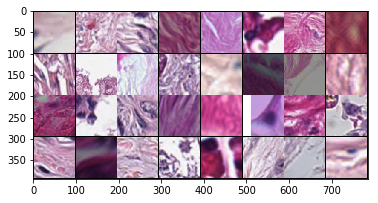

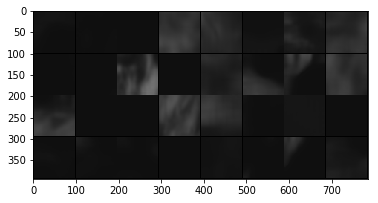

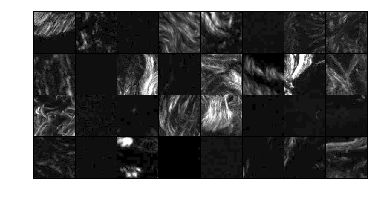

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


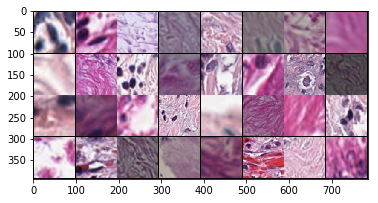

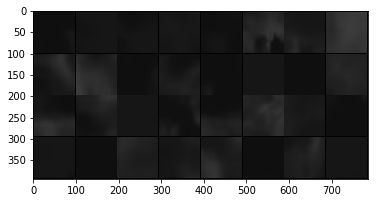

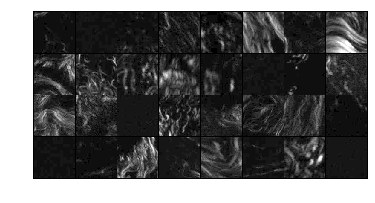

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


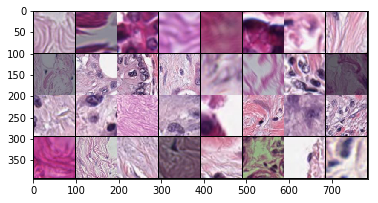

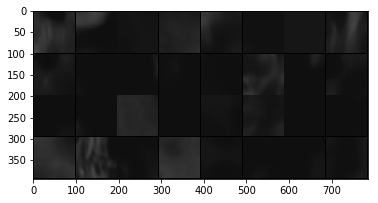

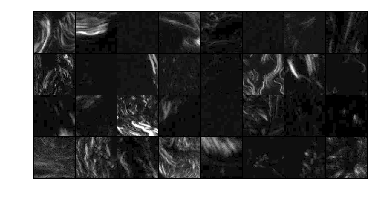

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


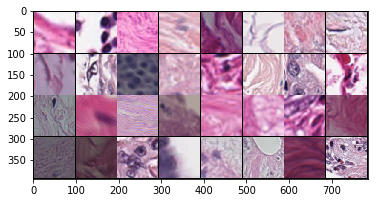

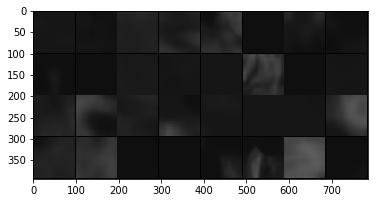

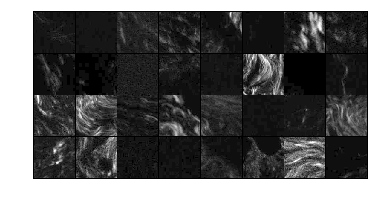

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


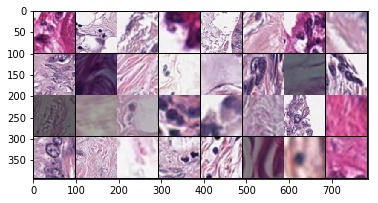

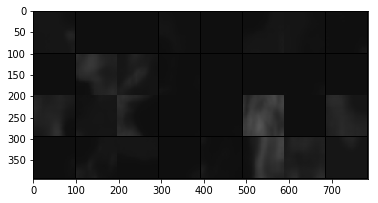

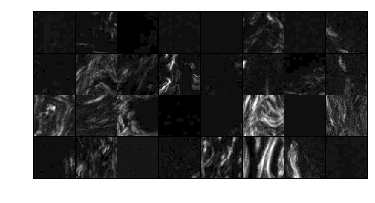

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


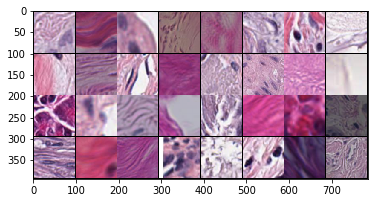

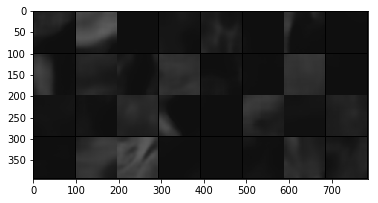

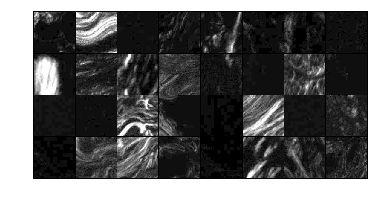

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


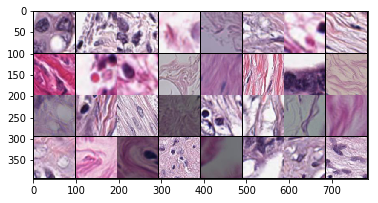

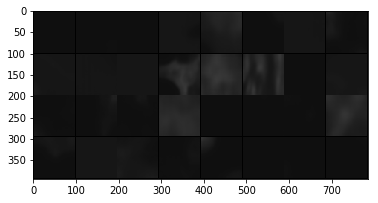

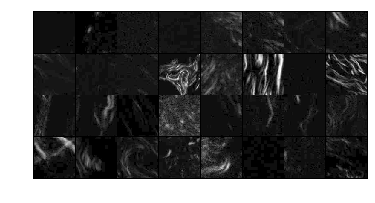

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


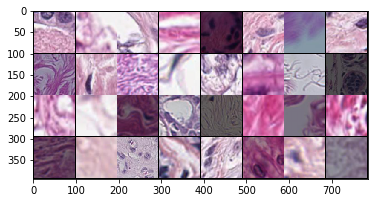

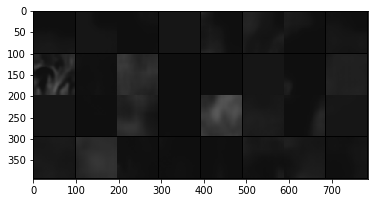

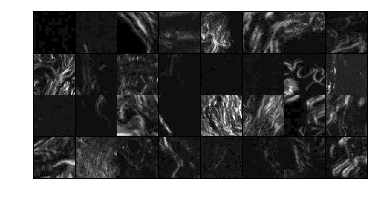

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


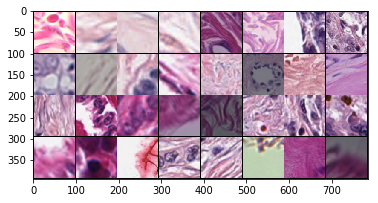

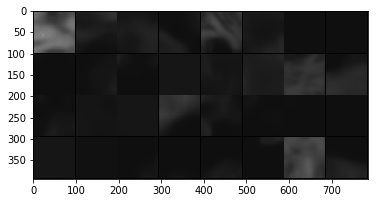

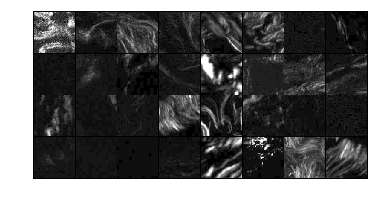

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


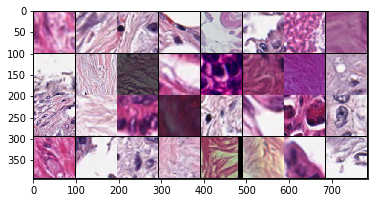

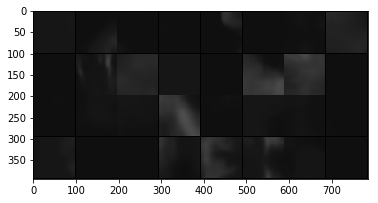

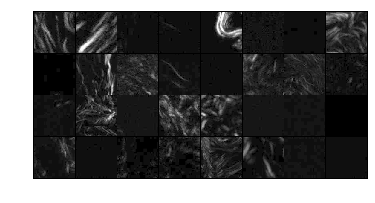

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


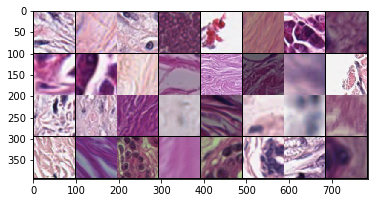

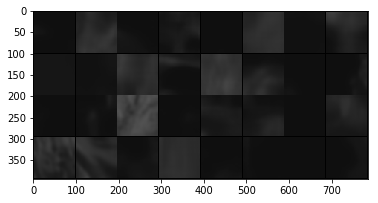

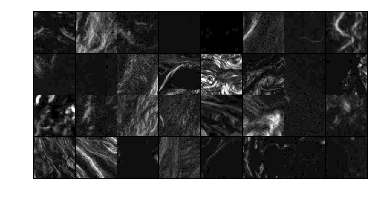

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


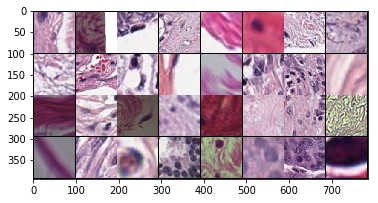

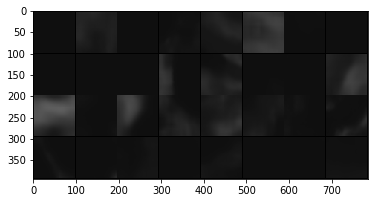

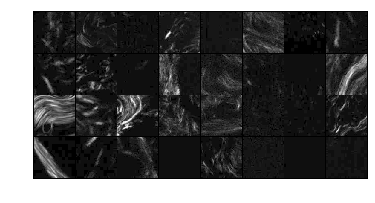

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


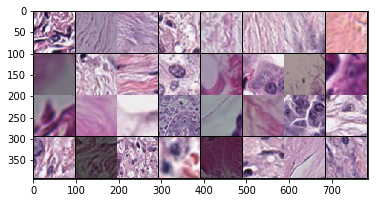

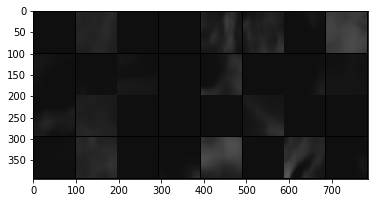

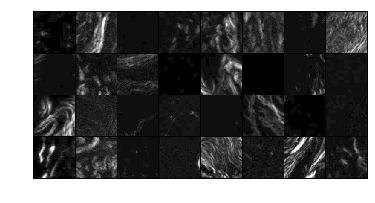

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


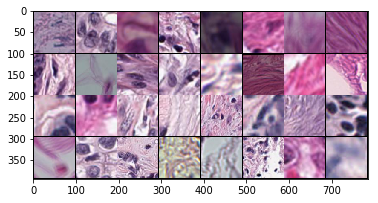

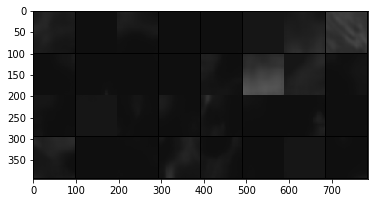

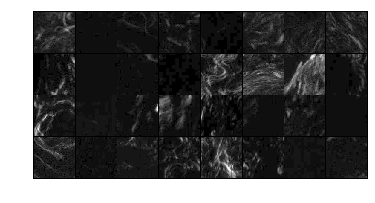

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


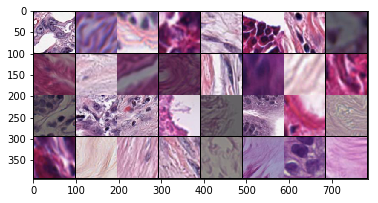

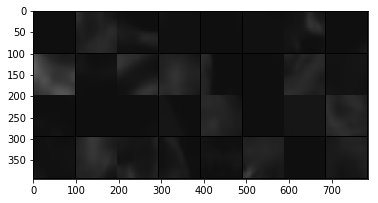

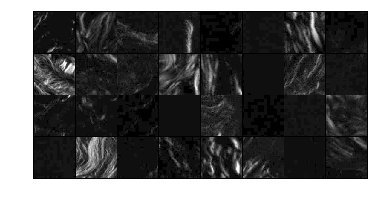

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


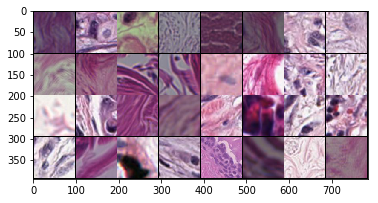

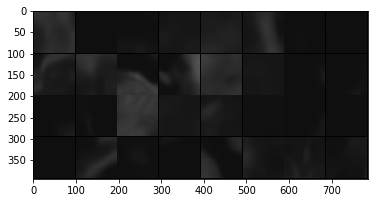

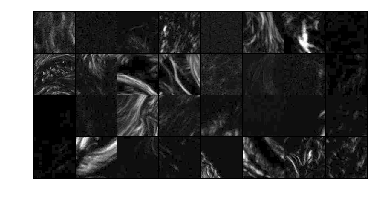

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([32, 1, 96, 96])


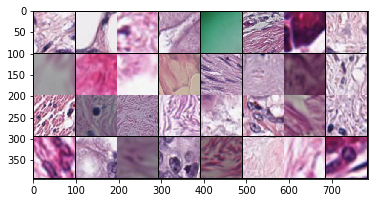

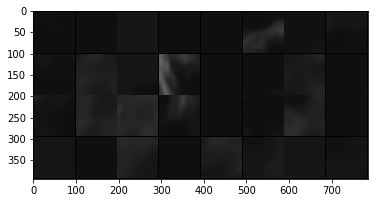

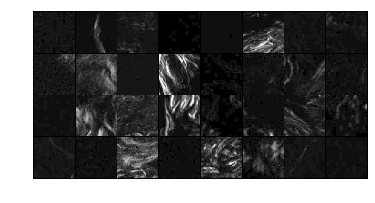

In [17]:
test()